<a href="https://colab.research.google.com/github/memelordmaddy/WiDS-2023/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Replace the following path with the path to your zipped file on Google Drive
zip_path = '/content/gdrive/My Drive/brain_images_dataset.zip'

# Define the extraction path
extracted_path = '/content/dataset'

# Unzip the file
!unzip "$zip_path" -d "$extracted_path"


In [ ]:
from torchvision.transforms import Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter
# Define the transformation to apply to the images
transform = transforms.Compose([
    Resize((240, 240)),  # Resize the image to 240x240 pixels
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for data augmentation
    transforms.RandomVerticalFlip(),    # Random vertical flip for data augmentation
    transforms.RandomRotation(20),      # Random rotation for data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to mean=0.5 and std=0.5
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=extracted_path, transform=transform)

# Define the DataLoader to handle batching and shuffling
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
from torch.utils.data import random_split

# Define the size of the training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size   # 20% for testing

# Use random_split to create the training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the CNN model
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(115200, 256)  # Adjusted the input size based on the output of conv3
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()  # Added ReLU activation module
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)  # logits for BCEWithLogitsLoss
        return logits

# Instantiate the model and move it to the GPU if available
model = BrainTumorCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
# Define early stopping and model checkpointing
class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.checkpoint_path)

# Instantiate EarlyStopping class
early_stopping = EarlyStopping(patience=5, delta=0.001)

In [ ]:
# Training loop with early stopping and model checkpointing
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float().view(-1, 1)).item()

            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels.view(-1, 1)).sum().item()

    val_loss /= len(test_loader)
    accuracy = correct / total * 100
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model weights
model.load_state_dict(torch.load(early_stopping.checkpoint_path))

# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        test_total += labels.size(0)
        test_correct += (predicted == labels.view(-1, 1)).sum().item()

test_accuracy = test_correct / test_total * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/20], Loss: 0.9126, Val Loss: 0.5674, Accuracy: 18.63%
Epoch [2/20], Loss: 0.1875, Val Loss: 0.7531, Accuracy: 18.63%
Epoch [3/20], Loss: -0.5454, Val Loss: 0.8684, Accuracy: 19.61%
Epoch [4/20], Loss: 0.2457, Val Loss: 1.4205, Accuracy: 17.65%
Epoch [5/20], Loss: -0.2894, Val Loss: 0.9258, Accuracy: 18.63%
Epoch [6/20], Loss: 0.0404, Val Loss: 1.4251, Accuracy: 17.65%
Early stopping
Test Accuracy: 18.63%


IndexError: index 69 is out of bounds for dimension 0 with size 6

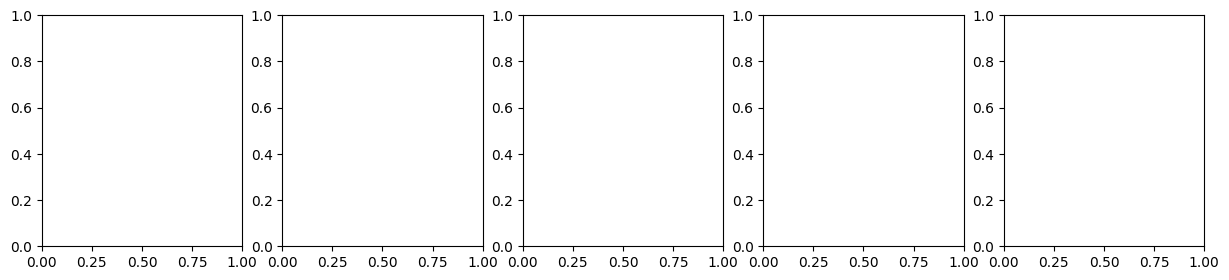

In [ ]:
from torchvision import transforms

# Assuming 'test_loader' is your DataLoader for the test set
# and 'model' is your trained model

# Set the model to evaluation mode
model.eval()

# Iterate through the test set and make predictions
predictions = []
labels = []

with torch.no_grad():
    for inputs, true_labels in test_loader:
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)

        # Forward pass
        outputs = model(inputs)
        predicted_labels = sigmoid(outputs) > 0.5

        predictions.extend(predicted_labels.cpu().numpy())
        labels.extend(true_labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
labels = np.array(labels)

# Visualize some results
num_samples = min(5, len(predictions), len(test_loader.dataset))  # Ensure not to exceed the number of available samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    sample_index = np.random.randint(len(predictions))
    prediction = predictions[sample_index]
    label = labels[sample_index]

    image = transforms.ToPILImage()(inputs[sample_index].cpu())
    axes[i].imshow(image)
    axes[i].set_title(f'Predicted: {prediction}, Actual: {label}')
    axes[i].axis('off')

plt.show()